In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
from importlib import reload
import sys
import weibull
sys.path.append('../../..')

import stlstuff as sls
import imagestuff as ims
import statstuff as sts
import retrievestuff as rs

In [2]:
%matplotlib notebook

In [3]:
def Weibull(Z2,sigma2W,etaW):
    # Getting the Weibull distribution
    rhoW = etaW/(sigma2W)*(Z2/sigma2W)**(etaW-1)*np.exp(-(Z2/sigma2W)**etaW)
    return rhoW

In [4]:
# Loading in the compressed data
Flattenedfilename = 'Segments3_compr_flat_filt.npz'; print(Flattenedfilename)
Roughnessfilename = Flattenedfilename[0:-4]+'_roughness.jpg'; print(Roughnessfilename)
flattenedfile = np.load(Flattenedfilename)
xgridtot = flattenedfile['xgridtot']
ygridtot = flattenedfile['ygridtot']
zgridtot = flattenedfile['zgridtot']
nsegments = (len(xgridtot)); print(nsegments)

# This folder
cwd = os.getcwd(); i = cwd.index('crystals'); case_and_folder = cwd[i+9:]; print(case_and_folder)

Segments3_compr_flat_filt.npz
Segments3_compr_flat_filt_roughness.jpg
1
2019-07-02/case2.0 (calibration)


In [5]:
# Histogram accumulation
countslist = []
accumlist = [] # all
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
plotthisone = accumlist
print('Accumulating segments', accumlist)
print('Plotting segments', plotthisone)

# Parameters for binning
Z2minforhist = 0
Z2maxforhist = .035
print('Z2 ranging from', Z2minforhist, 'to', Z2maxforhist)
nbins_max = 10
print('Max number of bins specified is', nbins_max)
Ntot = np.size(zgridtot[0]) # Just using the first one for a size estimate
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(Z2minforhist,Z2maxforhist,nbins); #print(Z2bins)
Z2theory = np.linspace(Z2bins[1],Z2bins[-1]) # This is for Weibull plots
levels = 3; print('Using levels =', levels, 'for uncertainty analysis')


Accumulating segments [0]
Plotting segments [0]
Z2 ranging from 0 to 0.035
Max number of bins specified is 10
Sturges rule says maxbins = 12
Using nbins =  10
Using levels = 3 for uncertainty analysis


Original =  2070
4 0 518 [218 131  76  46  20  11   7   2   2]
4 1 518 [195 136  86  44  30   6   4   8   1]
4 2 517 [210 117  89  52  24  10   6   2   2]
4 3 517 [219 120  85  44  21   9   8   5   3]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.0072018331949961515
statsigma =  0.08486361525999321


<IPython.core.display.Javascript object>


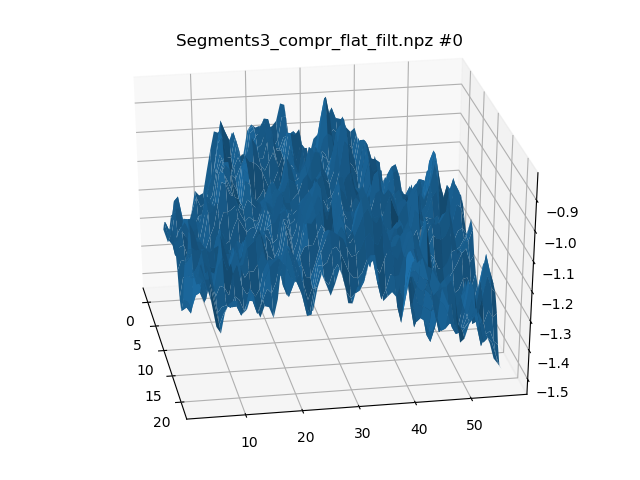

std dev of height =  0.12035584234177561
integral =  0.0030822623501979294


<IPython.core.display.Javascript object>


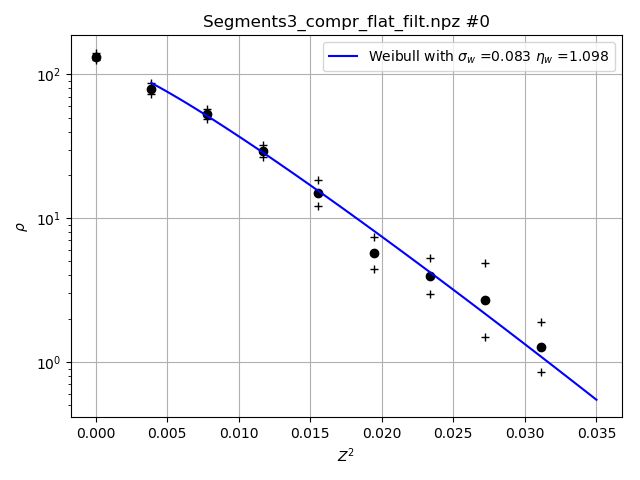

[125.37982471  73.50388431  49.25583972  26.8253284   12.25144223
   4.42367337   2.97963114   1.48510573   0.84968099]


In [6]:
# Arrays for accumulating 
counts_list = []
meanZ2_list = []
Z2flat_list = []

# Looping over segments
for isegment in range(nsegments):

    # Pull out the next segment
    sollast = zgridtot[isegment]
    xgrid = xgridtot[isegment] 
    ygrid = ygridtot[isegment]
    Ny, Nx = np.shape(sollast); #print(sollast.shape)
    Ntot = np.size(sollast)
    dx = xgrid[0,1]-xgrid[0,0]; #print('dx =', dx)
    dy = ygrid[1,0]-ygrid[0,0]; #print('dy =', dy)
    
    # Get the probability distribution in Z2
    counts, bins, meanZ2, Z2flat, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=levels)
    print('meanZ2 = ', meanZ2)
    print('statsigma = ', np.sqrt(meanZ2))

    # Plot if we want
    if isegment in plotthisone:
        
        # Graph the surface
        fig1 = plt.figure()
        ax = fig1.add_subplot(111, projection='3d')
        ax.plot_surface(xgrid, ygrid, sollast)
        title = Flattenedfilename+' #'+str(isegment)
        ax.set_title(title)
        ax.view_init(30, -10)
        
        # Normalize the distribution function, report stats
        integral_rho = np.trapz(counts, bins)
        print ('std dev of height = ', np.std(sollast))
        print('integral = ', integral_rho)
        counts = counts/integral_rho
        error = error/integral_rho

        # Graph the probability
        plt.figure()
        plt.semilogy(bins, counts, 'ok')
        countsplus = counts+error; #print(countsplus)
        countsminus = counts**2/countsplus; print(countsminus)
        plt.semilogy(bins, countsplus, '+k')
        plt.semilogy(bins, countsminus,'+k')
        plt.title(title)
        plt.xlabel(r'$Z^{2}$')
        plt.ylabel(r'$\rho$')
        plt.grid(True)
        
        # Attempt a best-fit
        ikeep = np.argwhere(Z2flat < Z2maxforhist)
        Z2flat_new = np.squeeze(Z2flat[ikeep])
        analysis = weibull.Analysis(Z2flat_new)
        analysis.fit(method='mle')
        etaW = analysis.beta
        sigma2W = analysis.eta
        sigmaW = np.sqrt(sigma2W)
        
        # Graph the best-fit probability
        myWeibull = Weibull(Z2theory,sigma2W,etaW)
        plt.semilogy(Z2theory, myWeibull, 'b',label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
        plt.legend()
        
    # Accumulate if we want
    if isegment in accumlist:
        counts_list.append(counts)
        meanZ2_list.append(meanZ2)
        Z2flat_list.append(Z2flat)

Original =  2070
4 0 518 [218 131  76  46  20  11   7   2   2]
4 1 518 [195 136  86  44  30   6   4   8   1]
4 2 517 [210 117  89  52  24  10   6   2   2]
4 3 517 [219 120  85  44  21   9   8   5   3]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.0072018331949961515
statsigma =  0.08486361525999321
integral =  0.0030822623501979294
eta_W =  1.0981266049362357
sigma_W =  0.08395467491698955


<IPython.core.display.Javascript object>


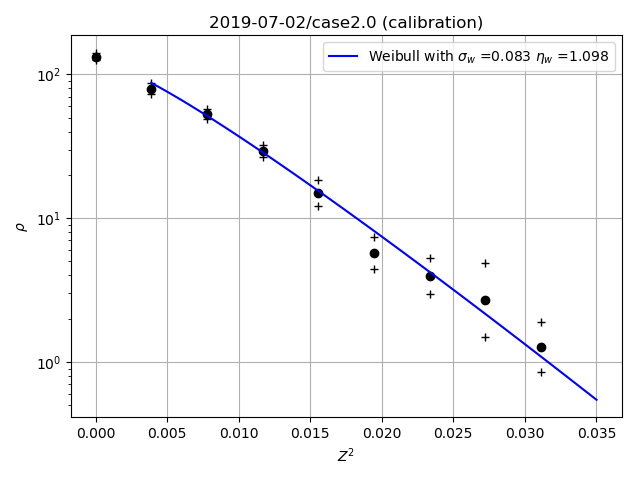

[125.37982471  73.50388431  49.25583972  26.8253284   12.25144223
   4.42367337   2.97963114   1.48510573   0.84968099]


In [7]:
# Sum up the accumulated informaion
Z2flat_total = []
for i in Z2flat_list:
    for j in i:
        Z2flat_total.append(j)
Z2flat_total = np.array(Z2flat_total)
ikeep = np.argwhere(Z2flat_total < Z2maxforhist)
Z2flat_new = np.squeeze(Z2flat_total[ikeep])

# Get the probability distribution in Z2
counts, bins, meanZ2, error = rs.getrhoofz2flat(Z2flat,nbins,Z2bins,levels)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

# Normalize the distribution function
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho

# Get the best Weibull parameters
analysis = weibull.Analysis(Z2flat_new)
analysis.fit(method='mle')
etaW = analysis.beta; print ('eta_W = ',etaW)
sigma2W = analysis.eta
sigmaW = np.sqrt(sigma2W); print ('sigma_W = ',sigmaW)

# Graph the probability
plt.figure()
plt.semilogy(bins, counts, 'ok')
countsplus = counts+error; #print(countsplus)
countsminus = counts**2/countsplus; print(countsminus)
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')
plt.title(case_and_folder)
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)

# Graph the best-fit probability
myWeibull = Weibull(Z2theory,sigma2W,etaW)
plt.semilogy(Z2theory, myWeibull, 'b',label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
plt.legend()

In [8]:
plt.savefig(Roughnessfilename)